In [1]:
import matplotlib.pyplot as plt 
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from keras.models import load_model

In [2]:
def pasar_a_datetime(fecha):
    #format_string = '%Y-%m-%d'
    anio,mes,dia= fecha.split('-')
    aux_dia = dia.split(' ')
    if len(aux_dia)>1:dia = aux_dia[0]
    res = datetime(int(anio),int(mes),int(dia))
    return res

In [3]:
def scale_datasets(x_train, x_test):

  """
  Standard Scale test and train data
  Z - Score normalization
  """
  standard_scaler = StandardScaler()
  x_train_scaled = pd.DataFrame(
      standard_scaler.fit_transform(x_train),
      columns=x_train.columns
  )
  x_test_scaled = pd.DataFrame(
      standard_scaler.transform(x_test),
      columns = x_test.columns
  )
  return x_train_scaled, x_test_scaled

In [4]:
publicaciones = pd.read_csv('C:/Users/54911/OneDrive/Escritorio/Data Science/Elecciones + IA/modeling/publicaciones_politicas.csv')
publicaciones['fecha'] = publicaciones['fecha'].map(lambda x:pasar_a_datetime(x))

In [5]:
semana_1 = publicaciones[(publicaciones['fecha']>datetime(2023,10,15)) & (publicaciones['fecha']<datetime(2023,10,22))]
semana_2 = publicaciones[(publicaciones['fecha']>datetime(2023,10,7)) & (publicaciones['fecha']<datetime(2023,10,16))]

In [6]:
def separar_fecha(data):
    data['dia'] = ''
    data['mes'] = ''
    data['anio'] = ''
    data['dia'] = data['fecha_mediana'].map(lambda x:x.day)
    data['mes'] = data['fecha_mediana'].map(lambda x:x.month)
    data['anio'] = data['fecha_mediana'].map(lambda x:x.year)

In [7]:
def encoding_Fuente(tabla,fuentes):
    #fuentes_labels = publicaciones['fuente'].unique()
    numbers = [i+1 for i in range(len(fuentes))]
    simple_encoding = dict(zip(fuentes,numbers))
    tabla['Fuente'] = tabla['Fuente'].map(lambda x:simple_encoding[x])

In [8]:
def formato_entrenado(datos_publicaciones):
    fuentes = datos_publicaciones['fuente'].unique()
    partidos = datos_publicaciones['Partido'].unique()
    #datos_publicaciones['fecha'] = datos_publicaciones['fecha'].map(lambda x:pasar_a_datetime(x))

    #datos_publicaciones['cantidad_likes'].quantile(0.95)
    datos_publicaciones = datos_publicaciones[datos_publicaciones['cantidad_likes']<25000]

    
    agrupado_likes = datos_publicaciones.groupby(['Partido','fuente'])['cantidad_likes'].median()
    fecha_median = datos_publicaciones['fecha'].median()

    df = pd.DataFrame()

    for p in list(partidos):

        if p in agrupado_likes.index:
            likes_partidos = agrupado_likes[p]
            fuentes_partido = likes_partidos.index
            likes_median = []

            for c in fuentes:
                if c in fuentes_partido:
                    likes_median.append(likes_partidos[c])
                else:
                    likes_median.append(0)
        
            df[p] = likes_median
        else:
            df[p] = [0]*len(fuentes)


    df['Fuente'] = fuentes
    df['fecha_mediana'] = fecha_median

    
    separar_fecha(df)
    df.drop(['fecha_mediana','anio'],axis=1,inplace=True)
    encoding_Fuente(df,fuentes)
    return df

In [9]:
semana_1_format = formato_entrenado(semana_1)
semana_2_format = formato_entrenado(semana_2)

In [10]:
model_primera_vuelta = load_model('C:/Users/54911/OneDrive/Escritorio/Data Science/Elecciones + IA/modeling/modelo_primera_vuelta')

In [11]:
scaler = StandardScaler()
semana_1_f_scaled = scaler.fit_transform(semana_1_format)
semana_2_f_scaled = scaler.fit_transform(semana_2_format)

In [12]:
prediccion_1 = model_primera_vuelta.predict(semana_1_f_scaled)
prediccion_2 = model_primera_vuelta.predict(semana_2_f_scaled)

1/1 [==============================] - 0s 83ms/step


In [13]:
partidos = semana_1_format.columns[:5]

In [17]:
resultados_mean = []
resultados_std = []
for i in range(5):
    resultados_mean.append(prediccion_2[:,i].mean())
    resultados_std.append(prediccion_2[:,i].std())


In [18]:
total = sum(resultados_mean)
resultados_norm = []
for r in resultados_mean:
    aux = 100*r/total
    resultados_norm.append(aux)

resultados_norm = [round(x,1) for x in resultados_norm]

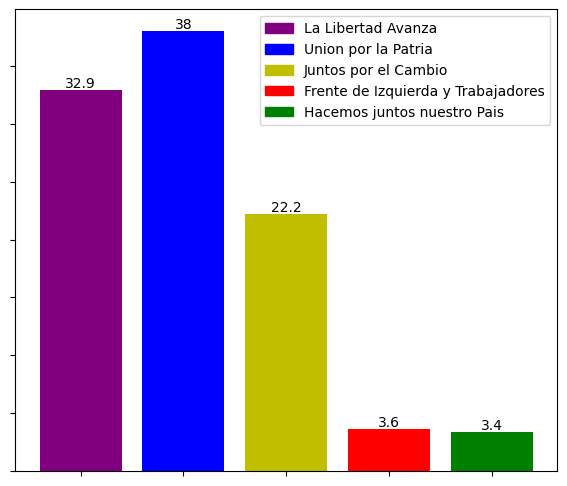

In [19]:
plt.figure(figsize=(7,6))
ax = plt.subplot()
colores = ['green','r','y','blue','purple']
bars = ax.bar(partidos,resultados_norm,color=colores[::-1])

ax.bar_label(bars)

colors = dict(zip(partidos,colores[::-1]))    
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]


plt.setp( ax.get_xticklabels(), visible=False)
plt.setp( ax.get_yticklabels(), visible=False)
ax.legend(handles, labels)

# Ballotaje


In [20]:
publicaciones_ballotaje = publicaciones[(publicaciones['Partido']=='La Libertad Avanza') | (publicaciones['Partido']=='Union por la Patria')]

In [21]:
semana_1_ballotaje = publicaciones_ballotaje[(publicaciones_ballotaje['fecha']>datetime(2023,11,11)) & (publicaciones_ballotaje['fecha']<datetime(2023,11,19))]
semana_2_ballotaje = publicaciones_ballotaje[(publicaciones_ballotaje['fecha']>datetime(2023,11,3)) & (publicaciones_ballotaje['fecha']<datetime(2023,11,11))]

In [22]:
formato_entrenado_ballotaje_1 = formato_entrenado(semana_1_ballotaje)
formato_entrenado_ballotaje_2 = formato_entrenado(semana_2_ballotaje)

In [23]:
scaler = StandardScaler()
ballotaje_scaled_1 = scaler.fit_transform(formato_entrenado_ballotaje_1)
ballotaje_scaled_2 = scaler.fit_transform(formato_entrenado_ballotaje_2)

In [24]:
modelo_ballotaje = load_model('C:/Users/54911/OneDrive/Escritorio/Data Science/Elecciones + IA/modeling/modelo_ballotaje')

In [25]:
prediccion_1_ballotaje = modelo_ballotaje.predict(ballotaje_scaled_1)
prediccion_2_ballotaje  = modelo_ballotaje.predict(ballotaje_scaled_2)

1/1 [==============================] - 0s 64ms/step


In [26]:
partidos = formato_entrenado_ballotaje_1.columns[:2]

In [27]:
resultados_mean = []
resultados_std = []
for i in range(2):
    resultados_mean.append(prediccion_1_ballotaje[:,i].mean())
    resultados_std.append(prediccion_1_ballotaje[:,i].std())


In [28]:
total = sum(resultados_mean)
resultados_norm = []
for r in resultados_mean:
    aux = 100*r/total
    resultados_norm.append(aux)

resultados_norm = [round(x,1) for x in resultados_norm]

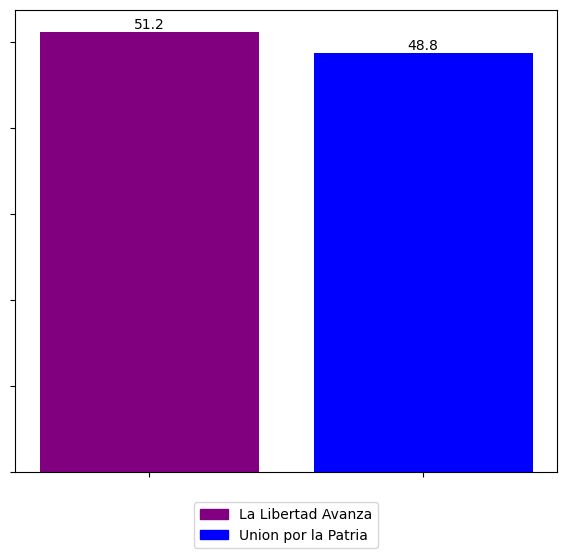

In [29]:
plt.figure(figsize=(7,6))
ax = plt.subplot()
colores = ['green','r','y','blue','purple']
bars = ax.bar(partidos,resultados_norm,color=colores[::-1])

ax.bar_label(bars)

colors = dict(zip(partidos,colores[::-1]))    
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]


plt.setp( ax.get_xticklabels(), visible=False)
plt.setp( ax.get_yticklabels(), visible=False)
ax.legend(handles, labels,loc='upper center', bbox_to_anchor=(0.5, -0.05))